# Smart Store OLAP Analysis (P6)
This notebook performs OLAP-style analysis on sales data from a smart store data warehouse using slicing, dicing, and drilldown techniques to answer a specific business question.


In [2]:
from pyspark.sql import SparkSession
from pathlib import Path

PROJECT_ROOT = Path("/Users/mk/smart-store-moses")
JDBC_JAR_PATH = PROJECT_ROOT / "lib" / "sqlite-jdbc-3.49.1.0.jar"
DB_PATH = PROJECT_ROOT / "data" / "dw" / "smart_sales.db"
DB_URL = f"jdbc:sqlite:{str(DB_PATH)}"

spark = SparkSession.builder \
    .appName("SmartStore OLAP") \
    .master("local[*]") \
    .config("spark.jars", str(JDBC_JAR_PATH)) \
    .config("spark.driver.extraClassPath", str(JDBC_JAR_PATH)) \
    .config("spark.executor.extraClassPath", str(JDBC_JAR_PATH)) \
    .getOrCreate()


25/04/21 00:17:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/21 00:17:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
df_customer = spark.read.format("jdbc") \
    .option("url", DB_URL) \
    .option("dbtable", "customer") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

df_customer.show()


+-----------+----------------+------+----------+--------------+----------------+
|customer_id|            name|region| join_date|loyalty_points|customer_segment|
+-----------+----------------+------+----------+--------------+----------------+
|       1001|   William White|  East|11/11/2021|             0|             0.0|
|       1002|    Wylie Coyote|  East| 2/14/2023|             0|             0.0|
|       1003|       Dan Brown|  West|10/19/2023|             0|             0.0|
|       1004|       Chewbacca|  West| 11/9/2022|             0|             0.0|
|       1005|          Dr Who| North| 8/18/2023|             0|             0.0|
|       1006|   Tiffany James| South|  6/7/2021|             0|             0.0|
|       1007|   Susan Johnson| South| 6/30/2023|             0|             0.0|
|       1008|      Tony Stark| North|  5/1/2020|             0|             0.0|
|       1009|    Jason Bourne|  West| 12/1/2020|             0|             0.0|
|       1010|Hermione Grange

In [11]:
df_sales = spark.read.format("jdbc") \
    .option("url", DB_URL) \
    .option("dbtable", "sale") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

df_sales = df_sales.withColumnRenamed("sale_id", "sales_id")

df_sales.show()


+--------+-----------+----------+-----------+---------+
|sales_id|customer_id|product_id|sale_amount|sale_date|
+--------+-----------+----------+-----------+---------+
|     550|       1008|       102|       39.1| 1/6/2024|
|     551|       1009|       105|      19.78| 1/6/2024|
|     552|       1004|       107|      335.1|1/16/2024|
|     553|       1006|       102|      195.5|1/16/2024|
|     554|       1005|       102|      117.3|1/25/2024|
|     555|       1001|       101|    2379.36|1/25/2024|
|     556|       1009|       104|      172.4|1/29/2024|
|     557|       1010|       101|    3172.48|1/29/2024|
|     558|       1002|       102|      312.8| 2/6/2024|
|     559|       1001|       106|     622.86| 2/6/2024|
|     560|       1010|       101|    6344.96| 2/6/2024|
|     561|       1005|       107|     469.14| 2/6/2024|
|     562|       1003|       108|      12.56| 2/8/2024|
|     563|       1006|       107|      67.02| 2/8/2024|
|     564|       1009|       107|     469.14| 2/

Join All Three Tables

In [12]:
df_joined = df_sales \
    .join(df_product, on="product_id", how="inner") \
    .join(df_customer, on="customer_id", how="inner")

df_joined.show(5)


+-----------+----------+--------+-----------+---------+------------+-----------+------+------+---------+--------------+----------------+
|customer_id|product_id|sales_id|sale_amount|sale_date|product_name|   category|  name|region|join_date|loyalty_points|customer_segment|
+-----------+----------+--------+-----------+---------+------------+-----------+------+------+---------+--------------+----------------+
|       1005|       107|     640|     268.08|9/30/2024|      jacket|   Clothing|Dr Who| North|8/18/2023|             0|             0.0|
|       1005|       107|     636|    1072.32| 9/5/2024|      jacket|   Clothing|Dr Who| North|8/18/2023|             0|             0.0|
|       1005|       107|     590|     603.18| 5/8/2024|      jacket|   Clothing|Dr Who| North|8/18/2023|             0|             0.0|
|       1005|       107|     561|     469.14| 2/6/2024|      jacket|   Clothing|Dr Who| North|8/18/2023|             0|             0.0|
|       1005|       106|     635|     177

In [14]:
from pyspark.sql.functions import to_date, month, when

df_joined = df_joined.withColumn("sale_date", to_date("sale_date"))

df_joined = df_joined.withColumn("month", month("sale_date"))

df_joined = df_joined.withColumn(
    "season",
    when(df_joined.month.isin(12, 1, 2), "Winter")
    .when(df_joined.month.isin(3, 4, 5), "Spring")
    .when(df_joined.month.isin(6, 7, 8), "Summer")
    .when(df_joined.month.isin(9, 10, 11), "Fall")
)


In [15]:
from pyspark.sql.functions import sum as _sum

olap_result = df_joined.groupBy("region", "season", "category") \
    .agg(_sum("sale_amount").alias("total_sales"))

olap_result.show()


+------+------+-----------+------------------+
|region|season|   category|       total_sales|
+------+------+-----------+------------------+
| South|  NULL|   Clothing|           3387.34|
| North|  NULL|   Clothing|           3583.52|
| North|  NULL|Electronics|1690.6200000000001|
|  East|  NULL|Electronics|          58400.28|
| South|  NULL|     Sports|             39.56|
|  East|  NULL|   Clothing|           4083.24|
|  West|  NULL|   Clothing|           2370.78|
|  East|  NULL|     Sports|            276.92|
|  West|  NULL|Electronics|          13656.52|
| North|  NULL|     Sports|            336.26|
| South|  NULL|Electronics|20711.520000000004|
|  West|  NULL|     Sports|             19.78|
+------+------+-----------+------------------+



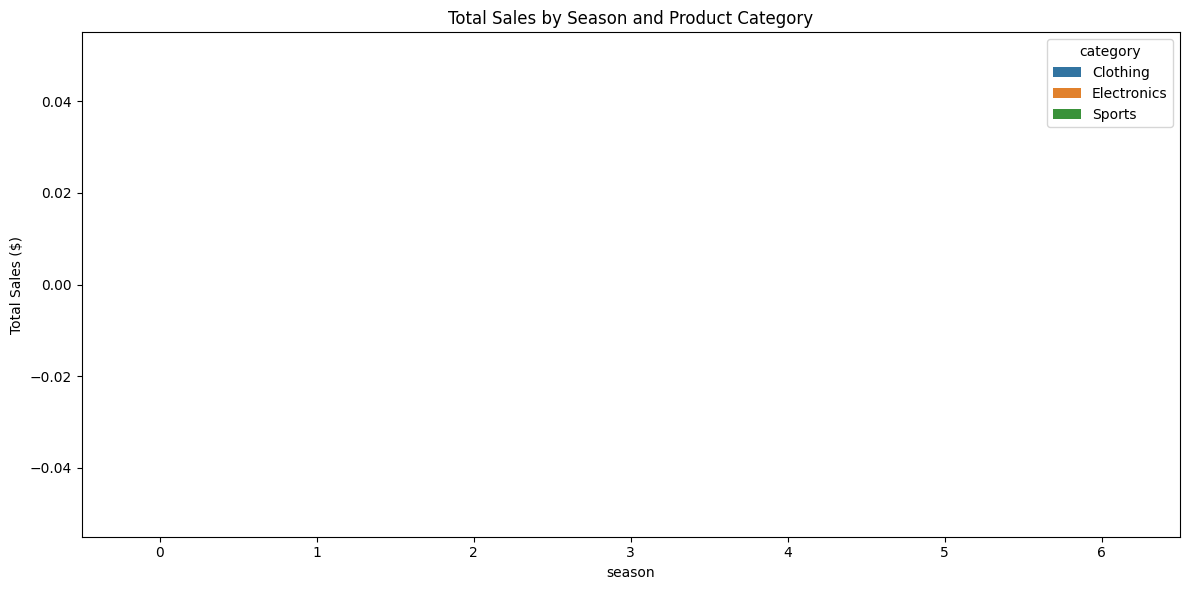

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Spark DF to pandas
pdf = olap_result.toPandas()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=pdf, x="season", y="total_sales", hue="category")
plt.title("Total Sales by Season and Product Category")
plt.ylabel("Total Sales ($)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [17]:
olap_result.show(10, truncate=False)


+------+------+-----------+------------------+
|region|season|category   |total_sales       |
+------+------+-----------+------------------+
|South |NULL  |Clothing   |3387.34           |
|North |NULL  |Clothing   |3583.52           |
|North |NULL  |Electronics|1690.6200000000001|
|East  |NULL  |Electronics|58400.28          |
|South |NULL  |Sports     |39.56             |
|East  |NULL  |Clothing   |4083.24           |
|West  |NULL  |Clothing   |2370.78           |
|East  |NULL  |Sports     |276.92            |
|West  |NULL  |Electronics|13656.52          |
|North |NULL  |Sports     |336.26            |
+------+------+-----------+------------------+
only showing top 10 rows



In [18]:
from pyspark.sql.functions import to_date, date_format

# Parse with a format like "M/d/yyyy" or "MM/dd/yyyy"
df_joined = df_joined.withColumn("sale_date", to_date("sale_date", "M/d/yyyy"))

# Check if sale_date worked
df_joined.select("sale_date").show(5)


+---------+
|sale_date|
+---------+
|     NULL|
|     NULL|
|     NULL|
|     NULL|
|     NULL|
+---------+
only showing top 5 rows



In [22]:
from pyspark.sql.functions import month, when

df_joined = df_joined.withColumn("month", month("sale_date"))

df_joined = df_joined.withColumn(
    "season",
    when(df_joined.month.isin(12, 1, 2), "Winter")
    .when(df_joined.month.isin(3, 4, 5), "Spring")
    .when(df_joined.month.isin(6, 7, 8), "Summer")
    .when(df_joined.month.isin(9, 10, 11), "Fall")
)


In [23]:
olap_result = df_joined.groupBy("region", "season", "category") \
    .agg(_sum("sale_amount").alias("total_sales"))

olap_result.show()


+------+------+-----------+------------------+
|region|season|   category|       total_sales|
+------+------+-----------+------------------+
| South|  NULL|   Clothing|           3387.34|
| North|  NULL|   Clothing|           3583.52|
| North|  NULL|Electronics|1690.6200000000001|
|  East|  NULL|Electronics|          58400.28|
| South|  NULL|     Sports|             39.56|
|  East|  NULL|   Clothing|           4083.24|
|  West|  NULL|   Clothing|           2370.78|
|  East|  NULL|     Sports|            276.92|
|  West|  NULL|Electronics|          13656.52|
| North|  NULL|     Sports|            336.26|
| South|  NULL|Electronics|20711.520000000004|
|  West|  NULL|     Sports|             19.78|
+------+------+-----------+------------------+



In [21]:
from pyspark.sql.functions import to_date

# Reparse sale_date explicitly using the format in your data
df_joined = df_joined.withColumn("sale_date", to_date("sale_date", "M/d/yyyy"))


In [24]:
from pyspark.sql.functions import month, when

df_joined = df_joined.withColumn("month", month("sale_date"))

df_joined = df_joined.withColumn(
    "season",
    when(df_joined.month.isin(12, 1, 2), "Winter")
    .when(df_joined.month.isin(3, 4, 5), "Spring")
    .when(df_joined.month.isin(6, 7, 8), "Summer")
    .when(df_joined.month.isin(9, 10, 11), "Fall")
)


In [25]:
olap_result = df_joined.groupBy("region", "season", "category") \
    .agg(_sum("sale_amount").alias("total_sales"))

olap_result.show()


+------+------+-----------+------------------+
|region|season|   category|       total_sales|
+------+------+-----------+------------------+
| South|  NULL|   Clothing|           3387.34|
| North|  NULL|   Clothing|           3583.52|
| North|  NULL|Electronics|1690.6200000000001|
|  East|  NULL|Electronics|          58400.28|
| South|  NULL|     Sports|             39.56|
|  East|  NULL|   Clothing|           4083.24|
|  West|  NULL|   Clothing|           2370.78|
|  East|  NULL|     Sports|            276.92|
|  West|  NULL|Electronics|          13656.52|
| North|  NULL|     Sports|            336.26|
| South|  NULL|Electronics|20711.520000000004|
|  West|  NULL|     Sports|             19.78|
+------+------+-----------+------------------+



In [26]:
df_joined.select("sale_date").show(10, truncate=False)


+---------+
|sale_date|
+---------+
|NULL     |
|NULL     |
|NULL     |
|NULL     |
|NULL     |
|NULL     |
|NULL     |
|NULL     |
|NULL     |
|NULL     |
+---------+
only showing top 10 rows



In [27]:
df_sales.select("sale_date").distinct().show(20, truncate=False)


+---------+
|sale_date|
+---------+
|5/8/2024 |
|8/28/2024|
|9/30/2024|
|8/21/2024|
|8/14/2024|
|7/21/2024|
|5/17/2024|
|4/19/2024|
|5/19/2024|
|2/6/2024 |
|7/2/2024 |
|6/20/2024|
|8/2/2024 |
|5/29/2024|
|7/15/2024|
|6/6/2024 |
|8/1/2024 |
|1/6/2024 |
|6/17/2024|
|2/8/2024 |
+---------+
only showing top 20 rows



In [28]:
df_sales.select("sale_date").distinct().show(20, truncate=False)


+---------+
|sale_date|
+---------+
|5/8/2024 |
|8/28/2024|
|9/30/2024|
|8/21/2024|
|8/14/2024|
|7/21/2024|
|5/17/2024|
|4/19/2024|
|5/19/2024|
|2/6/2024 |
|7/2/2024 |
|6/20/2024|
|8/2/2024 |
|5/29/2024|
|7/15/2024|
|6/6/2024 |
|8/1/2024 |
|1/6/2024 |
|6/17/2024|
|2/8/2024 |
+---------+
only showing top 20 rows



In [29]:
from pyspark.sql.functions import to_date, trim

# Trim whitespace first, then convert
df_joined = df_joined.withColumn("sale_date", to_date(trim("sale_date"), "M/d/yyyy"))


In [30]:
from pyspark.sql.functions import month, when

df_joined = df_joined.withColumn("month", month("sale_date"))

df_joined = df_joined.withColumn(
    "season",
    when(df_joined.month.isin(12, 1, 2), "Winter")
    .when(df_joined.month.isin(3, 4, 5), "Spring")
    .when(df_joined.month.isin(6, 7, 8), "Summer")
    .when(df_joined.month.isin(9, 10, 11), "Fall")
)


In [31]:
from pyspark.sql.functions import sum as _sum

olap_result = df_joined.groupBy("region", "season", "category") \
    .agg(_sum("sale_amount").alias("total_sales"))

olap_result.show()


+------+------+-----------+------------------+
|region|season|   category|       total_sales|
+------+------+-----------+------------------+
| South|  NULL|   Clothing|           3387.34|
| North|  NULL|   Clothing|           3583.52|
| North|  NULL|Electronics|1690.6200000000001|
|  East|  NULL|Electronics|          58400.28|
| South|  NULL|     Sports|             39.56|
|  East|  NULL|   Clothing|           4083.24|
|  West|  NULL|   Clothing|           2370.78|
|  East|  NULL|     Sports|            276.92|
|  West|  NULL|Electronics|          13656.52|
| North|  NULL|     Sports|            336.26|
| South|  NULL|Electronics|20711.520000000004|
|  West|  NULL|     Sports|             19.78|
+------+------+-----------+------------------+



In [32]:
from pyspark.sql.functions import unix_timestamp, from_unixtime, to_date

# Step 1: Parse sale_date as a timestamp, then cast to date
df_joined = df_joined.withColumn(
    "sale_date",
    to_date(
        from_unixtime(
            unix_timestamp(trim("sale_date"), "M/d/yyyy")
        )
    )
)


In [33]:
from pyspark.sql.functions import month, when

df_joined = df_joined.withColumn("month", month("sale_date"))

df_joined = df_joined.withColumn(
    "season",
    when(df_joined.month.isin(12, 1, 2), "Winter")
    .when(df_joined.month.isin(3, 4, 5), "Spring")
    .when(df_joined.month.isin(6, 7, 8), "Summer")
    .when(df_joined.month.isin(9, 10, 11), "Fall")
)


In [34]:
from pyspark.sql.functions import sum as _sum

olap_result = df_joined.groupBy("region", "season", "category") \
    .agg(_sum("sale_amount").alias("total_sales"))

olap_result.show()


+------+------+-----------+------------------+
|region|season|   category|       total_sales|
+------+------+-----------+------------------+
| South|  NULL|   Clothing|           3387.34|
| North|  NULL|   Clothing|           3583.52|
| North|  NULL|Electronics|1690.6200000000001|
|  East|  NULL|Electronics|          58400.28|
| South|  NULL|     Sports|             39.56|
|  East|  NULL|   Clothing|           4083.24|
|  West|  NULL|   Clothing|           2370.78|
|  East|  NULL|     Sports|            276.92|
|  West|  NULL|Electronics|          13656.52|
| North|  NULL|     Sports|            336.26|
| South|  NULL|Electronics|20711.520000000004|
|  West|  NULL|     Sports|             19.78|
+------+------+-----------+------------------+



In [35]:
df_sales.select("sale_date").distinct().orderBy("sale_date").show(20, truncate=False)


+----------+
|sale_date |
+----------+
|1/16/2024 |
|1/25/2024 |
|1/29/2024 |
|1/6/2024  |
|10/10/2024|
|2/24/2024 |
|2/27/2024 |
|2/6/2024  |
|2/8/2024  |
|2/9/2024  |
|3/20/2024 |
|3/25/2024 |
|4/10/2024 |
|4/11/2024 |
|4/19/2024 |
|4/27/2024 |
|4/30/2024 |
|4/7/2024  |
|5/17/2024 |
|5/19/2024 |
+----------+
only showing top 20 rows



In [36]:
from pyspark.sql.functions import length

df_sales.select("sale_date", length("sale_date")).distinct().show(10)


+---------+-----------------+
|sale_date|length(sale_date)|
+---------+-----------------+
|8/21/2024|                9|
|1/16/2024|                9|
|7/21/2024|                9|
|2/24/2024|                9|
|8/28/2024|                9|
|3/20/2024|                9|
| 2/6/2024|                8|
| 2/9/2024|                8|
|7/25/2024|                9|
| 7/7/2024|                8|
+---------+-----------------+
only showing top 10 rows



In [37]:
from pyspark.sql.functions import regexp_replace, to_date

# Remove ALL spaces from sale_date (leading, trailing, in-between)
df_joined = df_joined.withColumn(
    "sale_date_clean",
    regexp_replace("sale_date", " ", "")  # removes ALL spaces
)


In [38]:
df_joined = df_joined.withColumn(
    "sale_date",
    to_date("sale_date_clean", "M/d/yyyy")
)


In [39]:
from pyspark.sql.functions import month, when

df_joined = df_joined.withColumn("month", month("sale_date"))

df_joined = df_joined.withColumn(
    "season",
    when(df_joined.month.isin(12, 1, 2), "Winter")
    .when(df_joined.month.isin(3, 4, 5), "Spring")
    .when(df_joined.month.isin(6, 7, 8), "Summer")
    .when(df_joined.month.isin(9, 10, 11), "Fall")
)


In [40]:
olap_result = df_joined.groupBy("region", "season", "category") \
    .agg(_sum("sale_amount").alias("total_sales"))

olap_result.show()


+------+------+-----------+------------------+
|region|season|   category|       total_sales|
+------+------+-----------+------------------+
| South|  NULL|   Clothing|           3387.34|
| North|  NULL|   Clothing|           3583.52|
| North|  NULL|Electronics|1690.6200000000001|
|  East|  NULL|Electronics|          58400.28|
| South|  NULL|     Sports|             39.56|
|  East|  NULL|   Clothing|           4083.24|
|  West|  NULL|   Clothing|           2370.78|
|  East|  NULL|     Sports|            276.92|
|  West|  NULL|Electronics|          13656.52|
| North|  NULL|     Sports|            336.26|
| South|  NULL|Electronics|20711.520000000004|
|  West|  NULL|     Sports|             19.78|
+------+------+-----------+------------------+



In [41]:
from pyspark.sql.functions import split

df_joined = df_joined.withColumn("month",
    split(regexp_replace("sale_date", " ", ""), "/").getItem(0).cast("int")
)


In [42]:
from pyspark.sql.functions import when

df_joined = df_joined.withColumn(
    "season",
    when(df_joined.month.isin(12, 1, 2), "Winter")
    .when(df_joined.month.isin(3, 4, 5), "Spring")
    .when(df_joined.month.isin(6, 7, 8), "Summer")
    .when(df_joined.month.isin(9, 10, 11), "Fall")
)


In [43]:
olap_result = df_joined.groupBy("region", "season", "category") \
    .agg(_sum("sale_amount").alias("total_sales"))

olap_result.show()


+------+------+-----------+------------------+
|region|season|   category|       total_sales|
+------+------+-----------+------------------+
| South|  NULL|   Clothing|           3387.34|
| North|  NULL|   Clothing|           3583.52|
| North|  NULL|Electronics|1690.6200000000001|
|  East|  NULL|Electronics|          58400.28|
| South|  NULL|     Sports|             39.56|
|  East|  NULL|   Clothing|           4083.24|
|  West|  NULL|   Clothing|           2370.78|
|  East|  NULL|     Sports|            276.92|
|  West|  NULL|Electronics|          13656.52|
| North|  NULL|     Sports|            336.26|
| South|  NULL|Electronics|20711.520000000004|
|  West|  NULL|     Sports|             19.78|
+------+------+-----------+------------------+



In [44]:
df_joined.select("sale_date", "month").distinct().show(20, truncate=False)


+---------+-----+
|sale_date|month|
+---------+-----+
|NULL     |NULL |
+---------+-----+



In [45]:
from pyspark.sql.functions import expr

df_joined = df_joined.withColumn("month", expr("CAST(SPLIT(TRIM(sale_date), '/')[0] AS INT)"))


In [46]:
df_joined = df_joined.withColumn(
    "season",
    when(df_joined.month.isin(12, 1, 2), "Winter")
    .when(df_joined.month.isin(3, 4, 5), "Spring")
    .when(df_joined.month.isin(6, 7, 8), "Summer")
    .when(df_joined.month.isin(9, 10, 11), "Fall")
)


In [47]:
olap_result = df_joined.groupBy("region", "season", "category") \
    .agg(_sum("sale_amount").alias("total_sales"))

olap_result.show()


+------+------+-----------+------------------+
|region|season|   category|       total_sales|
+------+------+-----------+------------------+
| South|  NULL|   Clothing|           3387.34|
| North|  NULL|   Clothing|           3583.52|
| North|  NULL|Electronics|1690.6200000000001|
|  East|  NULL|Electronics|          58400.28|
| South|  NULL|     Sports|             39.56|
|  East|  NULL|   Clothing|           4083.24|
|  West|  NULL|   Clothing|           2370.78|
|  East|  NULL|     Sports|            276.92|
|  West|  NULL|Electronics|          13656.52|
| North|  NULL|     Sports|            336.26|
| South|  NULL|Electronics|20711.520000000004|
|  West|  NULL|     Sports|             19.78|
+------+------+-----------+------------------+



In [48]:
from pyspark.sql.functions import regexp_replace, split, col

# Remove all whitespace
df_joined = df_joined.withColumn("sale_date_clean", regexp_replace(col("sale_date"), " ", ""))

# Extract month from the cleaned date string (as int)
df_joined = df_joined.withColumn("month", split("sale_date_clean", "/").getItem(0).cast("int"))

# Show to verify
df_joined.select("sale_date", "sale_date_clean", "month").distinct().show(10)


+---------+---------------+-----+
|sale_date|sale_date_clean|month|
+---------+---------------+-----+
|     NULL|           NULL| NULL|
+---------+---------------+-----+



In [57]:
df_sales.printSchema()
df_sales.select("sale_date").show(5)


root
 |-- sales_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- sale_amount: double (nullable = true)
 |-- sale_date: string (nullable = true)

+---------+
|sale_date|
+---------+
| 1/6/2024|
| 1/6/2024|
|1/16/2024|
|1/16/2024|
|1/25/2024|
+---------+
only showing top 5 rows



In [58]:
df_joined = df_sales \
    .join(df_product, "product_id") \
    .join(df_customer, "customer_id")


In [60]:
from pyspark.sql.functions import col

df_joined = df_sales.alias("s") \
    .join(df_product.alias("p"), col("s.product_id") == col("p.product_id")) \
    .join(df_customer.alias("c"), col("s.customer_id") == col("c.customer_id")) \
    .select(
        col("s.sale_date"),
        col("s.sale_amount"),
        col("p.category"),
        col("c.region")
    )
df_joined.show(5)

+---------+-----------+-----------+------+
|sale_date|sale_amount|   category|region|
+---------+-----------+-----------+------+
|9/30/2024|     268.08|   Clothing| North|
| 9/5/2024|    1072.32|   Clothing| North|
| 5/8/2024|     603.18|   Clothing| North|
| 2/6/2024|     469.14|   Clothing| North|
|8/28/2024|     177.96|Electronics| North|
+---------+-----------+-----------+------+
only showing top 5 rows



In [61]:
df_joined.select("sale_date").show(5)


+---------+
|sale_date|
+---------+
|9/30/2024|
| 9/5/2024|
| 5/8/2024|
| 2/6/2024|
|8/28/2024|
+---------+
only showing top 5 rows



In [62]:
from pyspark.sql.functions import split, col, when

# Extract month as integer from MM/DD/YYYY
df_joined = df_joined.withColumn(
    "month",
    split(col("sale_date"), "/").getItem(0).cast("int")
)

# Add season based on month
df_joined = df_joined.withColumn(
    "season",
    when(col("month").isin(12, 1, 2), "Winter")
    .when(col("month").isin(3, 4, 5), "Spring")
    .when(col("month").isin(6, 7, 8), "Summer")
    .when(col("month").isin(9, 10, 11), "Fall")
)


In [63]:
from pyspark.sql.functions import sum as _sum

olap_result = df_joined.groupBy("region", "season", "category") \
    .agg(_sum("sale_amount").alias("total_sales"))

olap_result.show()


+------+------+-----------+-----------------+
|region|season|   category|      total_sales|
+------+------+-----------+-----------------+
|  West|Winter|Electronics|            12.56|
|  East|  Fall|Electronics|         11942.32|
| North|Spring|     Sports|           178.02|
|  West|Winter|   Clothing|           976.64|
| North|Spring|Electronics|           800.82|
| South|Winter|   Clothing|           262.52|
| North|Winter|   Clothing|           625.54|
|  East|Winter|   Clothing|           1318.1|
|  East|Spring|Electronics|         13784.48|
| North|Summer|Electronics|889.8000000000001|
| South|Winter|Electronics|           649.74|
|  East|Summer|Electronics|         15654.34|
| South|Spring|   Clothing|            865.7|
|  East|Summer|   Clothing|          2346.14|
|  West|Summer|   Clothing|          1081.34|
|  West|Winter|     Sports|            19.78|
|  East|Winter|     Sports|           138.46|
|  West|Spring|   Clothing|            312.8|
| South|Summer|Electronics|7339.04

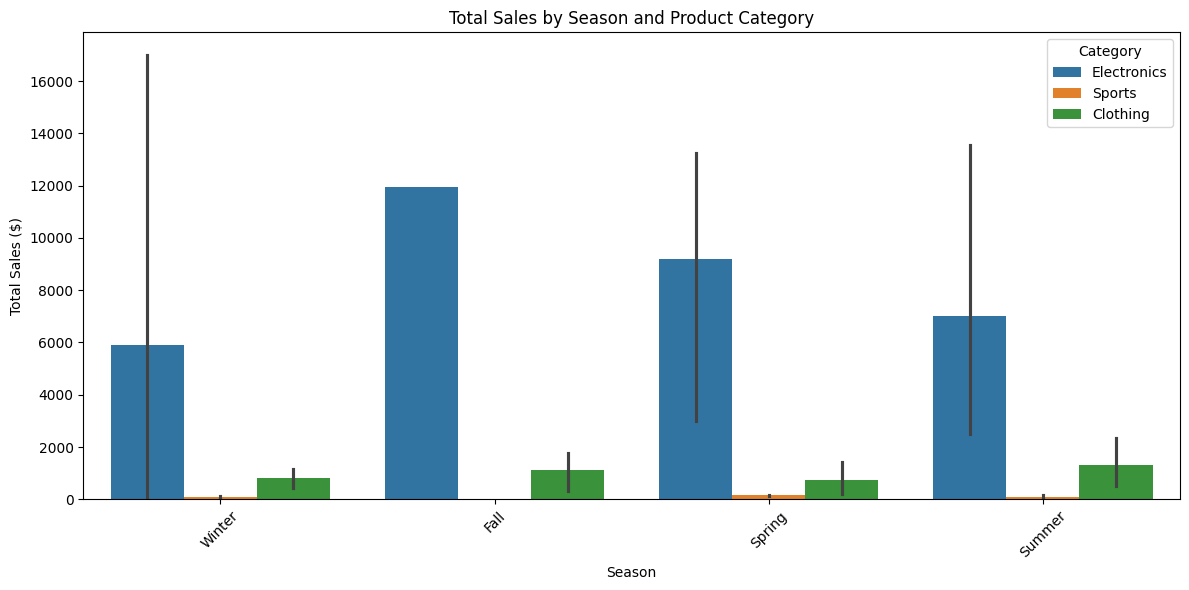

25/04/21 13:45:47 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 405640 ms exceeds timeout 120000 ms
25/04/21 13:45:47 WARN SparkContext: Killing executors is not supported by current scheduler.
25/04/21 13:45:54 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark to Pandas
pdf = olap_result.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=pdf, x="season", y="total_sales", hue="category")

plt.title("Total Sales by Season and Product Category")
plt.xlabel("Season")
plt.ylabel("Total Sales ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Category")
plt.show()
